In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import tflearn, psutil, gc
from datetime import datetime
from rlx.utils import humanbytes
from skimage import segmentation
%matplotlib inline

## Simulating additional imagery info

We will use [`skimage.segmentation.quickshift`](http://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.quickshift) to obtain an extra channel for each image. With this, we **simulate** extra imagery information (such as level sets for satellite imagery or a flood risk map)

In [5]:
def load_cifar(batches = [1,2,3,4,5]):
    
    cifar10_dir ="/mnt/cifar-10-batches-py/"

    def unpickle(file):
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict

    def get_proper_images(raw):
        raw_float = np.array(raw, dtype=float)/255.
        images = raw_float.reshape([-1, 3, 32, 32])
        images = images.transpose([0, 2, 3, 1])
        return images

    def onehot_labels(labels):
        return np.eye(10)[labels]

    imgs, labels = None, None
    for f in ["data_batch_%d" for d in batches]:
        d = unpickle(cifar10_dir+"data_batch_1")
        i,l = get_proper_images(d["data"]), np.r_[d["labels"]]
        imgs,labels = (i,l) if imgs is None else (np.concatenate((imgs,i)), np.concatenate((labels, l)))

    ohlabs = onehot_labels(labels)
    return imgs, labels, ohlabs

In [6]:
imgs, labels, ohlabs = load_cifar(batches = [1])

print "imgs  ", imgs.shape
print "labels", labels.shape
print "onehot", ohlabs.shape

train_pct = .8
shuffle   = True

idxs = np.random.permutation(len(imgs)) if shuffle else np.arange(len(imgs))
n = int(len(imgs)*train_pct)
train_idxs, test_idxs = idxs[:n], idxs[n:]
train_imgs   = imgs[train_idxs]#.mean(axis=3).reshape(-1,32,32,1)
train_ohlabs = ohlabs[train_idxs]
train_labels = labels[train_idxs]

test_imgs   = imgs[test_idxs]#.mean(axis=3).reshape(-1,32,32,1)
test_ohlabs = ohlabs[test_idxs]
test_labels = labels[test_idxs]
cnames = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "boat", "truck"]
print "train ", train_imgs.shape
print "test  ", test_imgs.shape
#show_image_mosaic(train_imgs, train_labels)
print "free mem", humanbytes(psutil.virtual_memory().free)

imgs   (10000, 32, 32, 3)
labels (10000,)
onehot (10000, 10)
train  (8000, 32, 32, 3)
test   (2000, 32, 32, 3)
free mem 868.29 MB


## we now apply the segmentation to random images

100% (10 of 10) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (10 of 10) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00


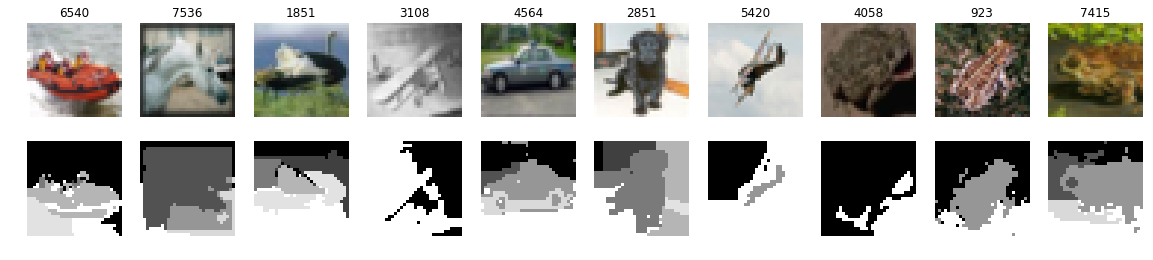

In [7]:

from rlx.utils import pbar
idxs = np.random.permutation(range(len(train_imgs)))[:10]
imgs = train_imgs[idxs]
plt.figure(figsize=(20,4))
simgs = np.zeros((imgs.shape[0], imgs.shape[1], imgs.shape[2]))
for i in pbar()(range(len(imgs))):
    simgs[i] = segmentation.quickshift(imgs[i], max_dist=15, ratio=.8)

for i in pbar()(range(len(imgs))):
    plt.subplot(2,10,i+1)
    plt.imshow(imgs[i])
    plt.axis("off")
    plt.title("%d"%idxs[i])
    
    plt.subplot(2,10,i+11)
    plt.imshow(simgs[i], cmap=plt.cm.Greys_r)
    plt.axis("off")
